# Exploratory data analysis of the Upworthy Archive dataset

### Questions to answer: How to write an attractive headline?

### Setup

In [46]:
import pandas as pd
import numpy as np

import textstat
from scipy.stats import spearmanr, pearsonr
from statsmodels.api import OLS
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set_theme()
pd.set_option('display.max_colwidth', None)

data_dir = 'resources/data/'

[nltk_data] Downloading package punkt to /home/zmjm/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/zmjm/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/zmjm/nltk_data...


In [2]:
packages = pd.read_csv(data_dir + 'packages.csv')
packages.head()

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner
0,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmare.' And I *Really* Hope It Comes True.,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""Walmart's worst nightmare,"" I found myself wishing the nightmare would come true.</p>",theyre-being-called-walmarts-worst-nightmare-and-i-really-hope-it-comes-true-ma3-3b,Anyone who's ever felt guilty about shopping about Walmart will be relieved to see this.,NaN,3052,150,True,True
1,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmare.' And I *Really* Hope It Comes True.,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""Walmart's worst nightmare,"" I found myself wishing the nightmare would come true.</p>",theyre-being-called-walmarts-worst-nightmare-and-i-really-hope-it-comes-true-ma3-3c,Walmart is getting schooled by another retailer. And my God it does it feel good.,NaN,3033,122,False,False
2,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmare.' And I *Really* Hope It Comes True.,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""Walmart's worst nightmare,"" I found myself wishing the nightmare would come true.</p>",theyre-being-called-walmarts-worst-nightmare-and-i-really-hope-it-comes-true-ma3-3d,"Walmart may not be crapping their pants over their new competition, but I sincerely hope they do.",NaN,3092,110,False,False
3,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546bc55335992b86c8000043,Things that matter. Pass 'em on.,"<p>DISCLOSURE: I'm a dude. I have cried on multiple occasions this year. I have also yelled manly yells at sporting events. I am a stay-at-home-parent 1 day a week. I'm totally cool with having emotions. These are things than many struggle with because, well... I'll let Laci Green explain.</p>",this-is-what-sexism-against-men-sounds-like-am2-5a,"If you ever wondered, ""but what about the men?,"" this one is all about the men.",NaN,3526,90,False,False
4,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546d900426714cd2dd00002e,Things that matter. Pass 'em on.,"<p>DISCLOSURE: I'm a dude. I have cried on multiple occasions this year. I have also yelled manly yells at sporting events. I am a stay-at-home-parent 1 day a week. I'm totally cool with having emotions. These are things than many struggle with because, well... I'll let Laci Green explain.</p>",this-is-what-sexism-against-men-sounds-like-am2-5b,"If you ever wondered, ""but what about the men?,"" this one is all about the men.",NaN,3506,120,True,False


In [3]:
packages.isna().sum()

created_at          0
test_week           0
test_id             0
headline            1
image_id          181
excerpt         16027
lede              104
slug                0
share_text     129917
share_image    101017
impressions         0
clicks              0
first_place         0
winner              0
dtype: int64

If we focus on the effect of headline, we can ignore the tests with no headline

In [4]:
packages.dropna(inplace=True, subset=['headline'])
packages.isna().sum()

created_at          0
test_week           0
test_id             0
headline            0
image_id          181
excerpt         16026
lede              104
slug                0
share_text     129916
share_image    101017
impressions         0
clicks              0
first_place         0
winner              0
dtype: int64

In [5]:
packages['click_rate'] = packages['clicks'] / packages['impressions']
packages['click_rate'].describe()

count    150816.000000
mean          0.015789
std           0.012371
min           0.000000
25%           0.007458
50%           0.012509
75%           0.020386
max           0.183401
Name: click_rate, dtype: float64

In [6]:
packages.isna().sum()

created_at          0
test_week           0
test_id             0
headline            0
image_id          181
excerpt         16026
lede              104
slug                0
share_text     129916
share_image    101017
impressions         0
clicks              0
first_place         0
winner              0
click_rate          0
dtype: int64

In [7]:
packages.reset_index(inplace=True)

### Some initial statistical analysis

We can first perform some initial statistical analysis to get a feel for the data.

- The distribution of sizes of tests

In [8]:
test_size = packages.groupby('test_id').size()
test_size.describe()

count    32487.000000
mean         4.642349
std          1.195652
min          1.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         20.000000
dtype: float64

In [9]:
count = test_size.value_counts().sort_index()
count

1         2
2       847
3      1178
4     16967
5      6169
6      5682
7       889
8       517
9       112
10       57
11       32
12        9
13        7
14        8
15        4
16        1
17        5
20        1
Name: count, dtype: int64

- The distribution of impressions among the same test

In [10]:
mean_impression = packages.groupby('test_id')['impressions'].mean()
mean_impression.describe()

count    32487.000000
mean      3589.900168
std       1469.346525
min          6.333333
25%       2748.250000
50%       3082.833333
75%       4097.600000
max      36695.750000
Name: impressions, dtype: float64

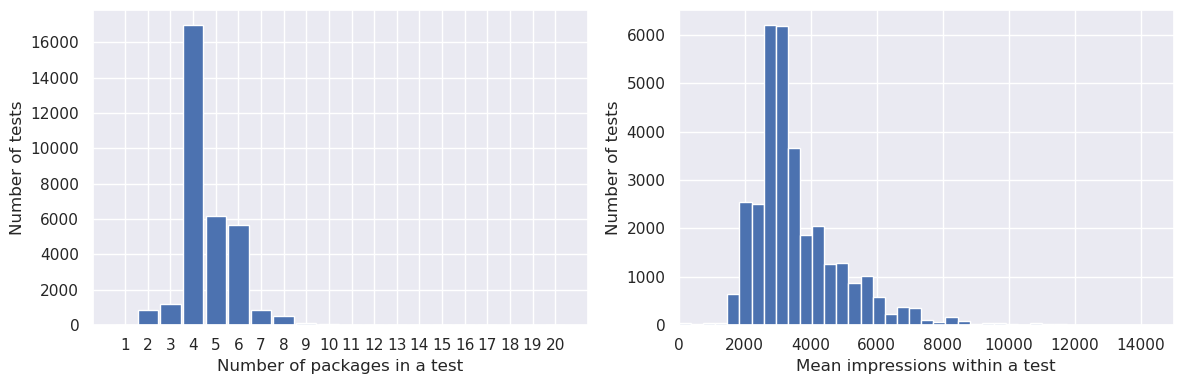

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(count.index, count.values, width=0.9)
plt.xticks(np.arange(1, 21))
plt.xlabel('Number of packages in a test')
plt.ylabel('Number of tests')

plt.subplot(1, 2, 2)
plt.hist(mean_impression, bins=100)
plt.xlim(0, 15000)
plt.xlabel('Mean impressions within a test')
plt.ylabel('Number of tests')

plt.tight_layout()
plt.show()

Most tests involve 2 ~ 8 packages, and the average number of impressions per package wthin a test is around 3600.

In [12]:
std_impression = packages.groupby('test_id')['impressions'].std()
std_impression.describe()

count    32485.000000
mean        94.347646
std        126.761386
min          0.000000
25%         43.412748
50%         62.024189
75%         93.257707
max       9812.190500
Name: impressions, dtype: float64

In [13]:
max_impression = packages.groupby('test_id')['impressions'].max()
min_impression = packages.groupby('test_id')['impressions'].min()
diff_impression = max_impression - min_impression
diff_impression.describe()

count    32487.000000
mean       217.895435
std        298.789671
min          0.000000
25%        103.000000
50%        149.000000
75%        223.000000
max      24061.000000
Name: impressions, dtype: float64

In [14]:
percentage_std = std_impression / mean_impression
percentage_std.describe()

count    32485.000000
mean         0.026438
std          0.030218
min          0.000000
25%          0.013253
50%          0.018956
75%          0.028633
max          1.696048
Name: impressions, dtype: float64

In [15]:
percentage_diff = diff_impression / mean_impression
percentage_diff.describe()

count    32487.000000
mean         0.061295
std          0.066937
min          0.000000
25%          0.031337
50%          0.045623
75%          0.067885
max          5.107701
Name: impressions, dtype: float64

In [16]:
r = pearsonr(percentage_diff, mean_impression)
r.correlation, r.pvalue, r.confidence_interval()

(-0.02182983970258248,
 8.321033913112635e-05,
 ConfidenceInterval(low=-0.032696250796532315, high=-0.01095826841497965))

In [17]:
percentage_diff_mean = percentage_diff.groupby(test_size).mean()
percentage_diff_mean

1     0.000000
2     0.035191
3     0.052757
4     0.070330
5     0.053337
6     0.048596
7     0.055179
8     0.059502
9     0.103688
10    0.072443
11    0.075598
12    0.059059
13    0.089404
14    0.068131
15    0.091473
16    0.231656
17    0.110744
20    0.049317
Name: impressions, dtype: float64

In [18]:
X = percentage_diff.dropna()
Y = percentage_std.dropna()
X = X[X.index.isin(Y.index)]
Y = Y[Y.index.isin(X.index)]

model = OLS(X, Y).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            impressions   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.070e+06
Date:                Fri, 10 Nov 2023   Prob (F-statistic):                        0.00
Time:                        23:37:20   Log-Likelihood:                          89107.
No. Observations:               32485   AIC:                                 -1.782e+05
Df Residuals:                   32484   BIC:                                 -1.782e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

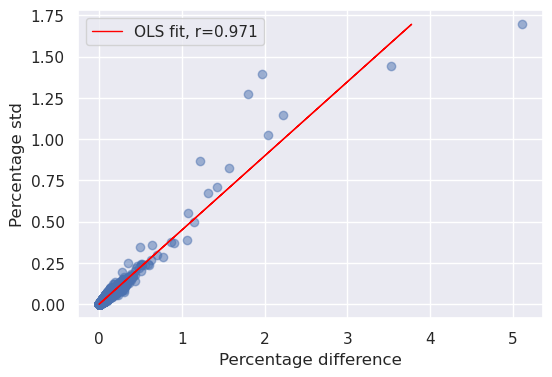

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(percentage_diff, percentage_std, alpha=0.5)
plt.plot(model.predict(), Y, color='red', linewidth=1, label=f'OLS fit, r={model.rsquared:.3f}')
plt.legend()
plt.xlabel('Percentage difference')
plt.ylabel('Percentage std')
plt.show()

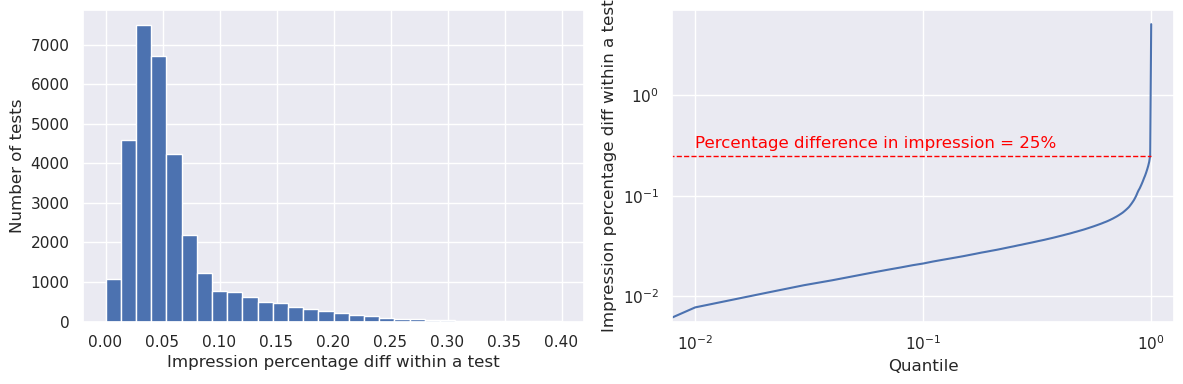

In [20]:
# plt.figure(figsize=(15, 4))
plt.figure(figsize=(12, 4))

plt.subplot(121)
percentage_diff.hist(bins=30, range=(0, 0.4))
plt.xlabel('Impression percentage diff within a test')
plt.ylabel('Number of tests')

plt.subplot(122)
percentage_diff.quantile(np.arange(0, 1.01, 0.01)).plot()
plt.hlines(0.25, 0, 1, color='red', linewidth=1, label='10%', linestyles='--')
plt.text(0.01, 0.3, 'Percentage difference in impression = 25%', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Quantile')
plt.ylabel('Impression percentage diff within a test')

# plt.scatter(test_size, percentage_diff)
# plt.plot(percentage_diff_mean, color='red', linewidth=1, label='Mean')
# plt.legend()
# plt.xticks(np.arange(1, 21))
# plt.xlabel('Number of packages in a test')
# plt.ylabel('Impression percentage diff within a test')

# plt.subplot(133)
# plt.scatter(percentage_diff, mean_impression, s=1)
# plt.xlim(-0.05, 1)
# plt.ylim(0, 25000)
# plt.xlabel('Impression percentage diff within a test')
# plt.ylabel('Mean impressions')

plt.tight_layout()
plt.show()

We can define `impression_percentage_std = std(impressions) / mean(impressions)`, which denotes the percentage of standard deviation of impressions among the same test. The average `impression_percentage_std` is around 0.03, which means the impressions are usually evenly distributed among the packages within the same test.

The tests that have very uneven impressions are probably not very useful for our analysis and can be thought of as outliers.

In [21]:
outliers = percentage_std[percentage_std > 0.3].sort_values(ascending=False)
outliers

test_id
5348bd88fe9c5a1bf500001b    1.696048
5351cef0c82697e770000071    1.440427
51d1bf83060dc3bf1200c41c    1.392623
5224f0addf1455730b000ea2    1.276242
51d1bea1ce97a4bc5800c5dd    1.147685
520268fddb7593ebfb0092ff    1.024795
5224f18861202c84890000e9    0.866776
520e63cb426dc5b4da000efd    0.823754
51e3a344be1e2cdda3002a74    0.711987
51e423dcd1cd7ec97e005e22    0.676041
5143608c220cb800020009cd    0.553615
51e3835fc65f02ebb4001b14    0.497066
526d4c1c94d1f182f600574f    0.387035
51d1de904dd785cfb40014d6    0.378663
51db74c459375e5052002cc7    0.369753
51cb56a86ce686af98002656    0.361804
51ddbd415d8e6fa6d2006471    0.349764
Name: impressions, dtype: float64

In [22]:
test_size[outliers.index]

test_id
5348bd88fe9c5a1bf500001b    9
5351cef0c82697e770000071    6
51d1bf83060dc3bf1200c41c    2
5224f0addf1455730b000ea2    2
51d1bea1ce97a4bc5800c5dd    3
520268fddb7593ebfb0092ff    4
5224f18861202c84890000e9    2
520e63cb426dc5b4da000efd    3
51e3a344be1e2cdda3002a74    3
51e423dcd1cd7ec97e005e22    3
5143608c220cb800020009cd    4
51e3835fc65f02ebb4001b14    4
526d4c1c94d1f182f600574f    5
51d1de904dd785cfb40014d6    4
51db74c459375e5052002cc7    4
51cb56a86ce686af98002656    3
51ddbd415d8e6fa6d2006471    2
dtype: int64

In [23]:
mean_impression[outliers.index]

test_id
5348bd88fe9c5a1bf500001b    4583.666667
5351cef0c82697e770000071    6812.000000
51d1bf83060dc3bf1200c41c      65.500000
5224f0addf1455730b000ea2      20.500000
51d1bea1ce97a4bc5800c5dd      19.333333
520268fddb7593ebfb0092ff      11.250000
5224f18861202c84890000e9      15.500000
520e63cb426dc5b4da000efd      14.000000
51e3a344be1e2cdda3002a74       6.333333
51e423dcd1cd7ec97e005e22      16.000000
5143608c220cb800020009cd    1552.250000
51e3835fc65f02ebb4001b14       8.750000
526d4c1c94d1f182f600574f      35.000000
51d1de904dd785cfb40014d6     392.750000
51db74c459375e5052002cc7      48.750000
51cb56a86ce686af98002656     273.000000
51ddbd415d8e6fa6d2006471    1259.500000
Name: impressions, dtype: float64

The distribution of click rates

In [24]:
packages.click_rate.describe()

count    150816.000000
mean          0.015789
std           0.012371
min           0.000000
25%           0.007458
50%           0.012509
75%           0.020386
max           0.183401
Name: click_rate, dtype: float64

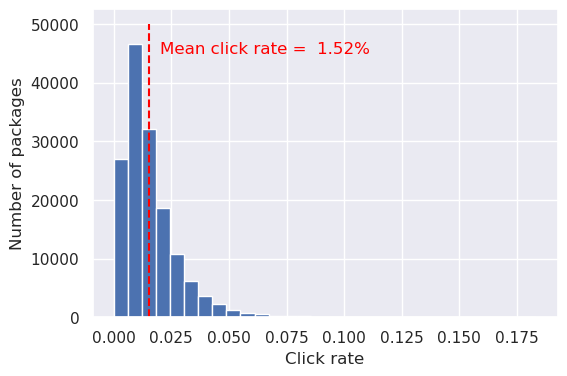

In [25]:
mean_click_rate = packages.clicks.sum() / packages.impressions.sum()

plt.figure(figsize=(6, 4))
packages.click_rate.hist(bins=30)
plt.plot([mean_click_rate, mean_click_rate], [0, 50000], color='red', linestyle='--')
plt.text(mean_click_rate + 0.005, 45000, f'Mean click rate = {100*mean_click_rate: .2f}%', color='red')
plt.xlabel('Click rate')
plt.ylabel('Number of packages')
plt.show()

The variation of click rates within a test

In [26]:
max_click_rate = packages.groupby('test_id')['click_rate'].max()
min_click_rate = packages.groupby('test_id')['click_rate'].min()
mean_click_rate = packages.groupby('test_id')['click_rate'].mean()
std_click_rate = packages.groupby('test_id')['click_rate'].std()
diff_click_rate = max_click_rate - min_click_rate
percentage_diff_click_rate = diff_click_rate / mean_click_rate

diff_click_rate.describe()

count    32487.000000
mean         0.008244
std          0.006406
min          0.000000
25%          0.004235
50%          0.006703
75%          0.010377
max          0.181818
Name: click_rate, dtype: float64

In [27]:
percentage_diff_click_rate.describe()

count    32480.000000
mean         0.611002
std          0.367380
min          0.000000
25%          0.340375
50%          0.543760
75%          0.808622
max          6.000000
Name: click_rate, dtype: float64

In [28]:
X = diff_click_rate.dropna()
Y = std_click_rate[X.index].dropna()
X = X[Y.index]

model = OLS(Y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             click_rate   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.650e+06
Date:                Fri, 10 Nov 2023   Prob (F-statistic):                        0.00
Time:                        23:37:21   Log-Likelihood:                      1.9327e+05
No. Observations:               32485   AIC:                                 -3.865e+05
Df Residuals:                   32484   BIC:                                 -3.865e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

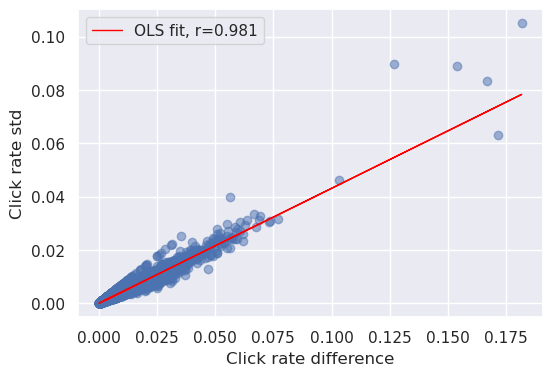

In [29]:
plt.figure(figsize=(6, 4))
plt.scatter(diff_click_rate, std_click_rate, alpha=0.5)
plt.plot(X, model.predict(X), color='red', linewidth=1, label=f'OLS fit, r={model.rsquared:.3f}')
plt.legend()
plt.xlabel('Click rate difference')
plt.ylabel('Click rate std')
plt.show()

In [30]:
percentage_diff_click_rate_modified = percentage_diff_click_rate.dropna()
r = pearsonr(percentage_diff_click_rate_modified, mean_impression[percentage_diff_click_rate_modified.index])
r.correlation, r.pvalue, r.confidence_interval()

(-0.12209920115668496,
 4.232911615363659e-108,
 ConfidenceInterval(low=-0.13279820660450112, high=-0.11137174413386566))

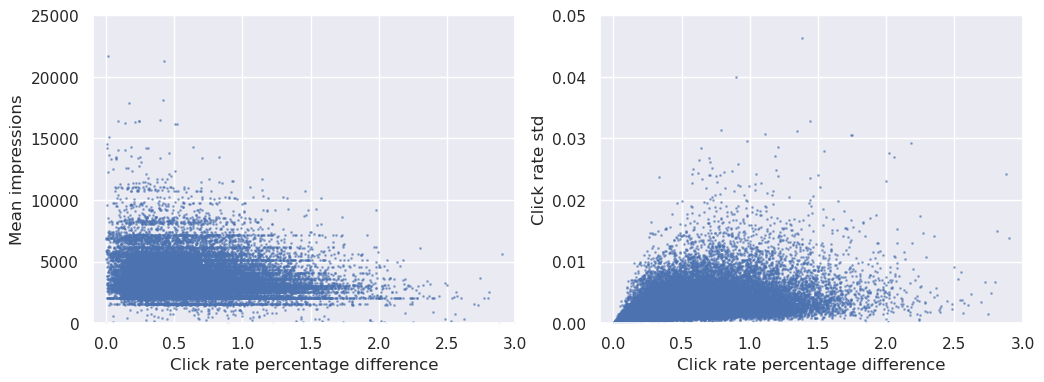

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(percentage_diff_click_rate, mean_impression, s=1, alpha=0.5)
plt.xlim(-0.1, 3)
plt.ylim(0, 25000)
plt.xlabel('Click rate percentage difference')
plt.ylabel('Mean impressions')

plt.subplot(1, 2, 2)
plt.scatter(percentage_diff_click_rate, std_click_rate, s=1, alpha=0.5)
plt.xlim(-0.1, 3)
plt.ylim(0, 0.05)
plt.xlabel('Click rate percentage difference')
plt.ylabel('Click rate std')
plt.show()

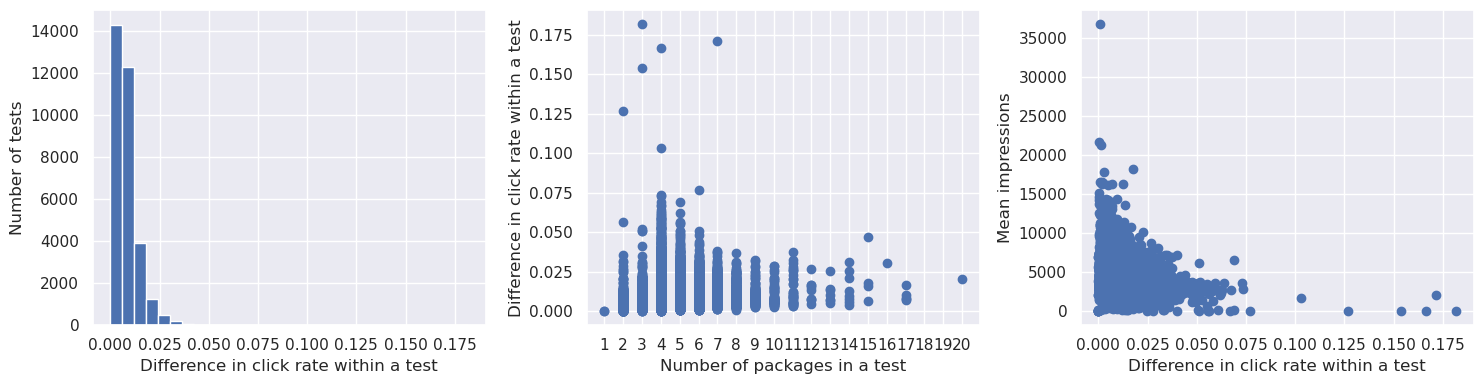

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
diff_click_rate.hist(bins=30)
plt.xlabel('Difference in click rate within a test')
plt.ylabel('Number of tests')

plt.subplot(132)
plt.scatter(test_size, diff_click_rate)
plt.xticks(np.arange(1, 21))
plt.xlabel('Number of packages in a test')
plt.ylabel('Difference in click rate within a test')

plt.subplot(133)
plt.scatter(diff_click_rate, mean_impression)
plt.xlabel('Difference in click rate within a test')
plt.ylabel('Mean impressions')

plt.tight_layout()
plt.show()

### Model of user response

The response of users depends on many factors, including the headline, the image, the time of day, the day of week, the user's mood, etc. The response is binary and stochastic, so we can model it as a Bernoulli random variable $X$ such that $X=1$ denotes that the user decides to click and $X=0$ is not to click.

To model the behavior of a group of users exposed to the same package, we can make the following assumptions:
- Each user make choice of whether to click on a headline independently
- The probability of clicking on a headline is the same for all users

The first assumption is reasonable because the users are typically independent of each other. The second assumption is not very realistic since each user should have his/her own preferences, but it is a good approximation if the number of users for the package is large.

Then the number of clicks $Y = X_1 + X_2 + ... + X_n $ out of $n$ users is a binomial random variable with parameters $n$ and $p$, where $p$ is the probability of clicking on a headline.
In practice, since the click rate is usually small, we can use a Poisson distribution to approximate the binomial distribution, therefore the variance of $Y$ is $np$ which is the same as the expected value.

From the observed $Y$, we can estimate the click rate $p$ as $\hat{p} = Y/n$ and the variance of the estimate is $\hat{p}/n$.
The t-statistic of the difference in click rate between two packages is then
$$ t = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}_1/n_1 + \hat{p}_2/n_2}} $$
where $n_1$ and $n_2$ are the number of users exposed to the two packages respectively.

Since the number of packages within a test could be more than 2, we define the pairwise t-statistic of a test as the t-statistic of the difference in click rate between two packages within the test. Then we can perform a t-test on the pairwise t-statistics to determine whether the difference in click rate between two packages is statistically significant.

Additionally, since we want to study the effect of headline, we can look into the pair of packages that are different only by their headlines.

In [33]:
tests = packages.groupby('test_id', group_keys=False)
t_stat = pd.DataFrame(columns=['test_id', 'A_package_id', 'B_package_id', 'A_headline', 'B_headline', 't_stat'])

for test_id, test in tqdm(tests):
    if len(test) >= 2:
        num_packages = len(test)
        
        for i in range(num_packages - 1):
            for j in range(i + 1, num_packages):

                test_a, test_b = test.iloc[i], test.iloc[j]
                
                if test_a.click_rate == 0 and test_b.click_rate == 0:
                    continue

                if test_a.headline == test_b.headline:
                    continue

                if test_a.image_id != test_b.image_id:
                    continue
                
                t = (test_a.click_rate - test_b.click_rate) / np.sqrt(
                    test_a.click_rate/test_a.impressions + test_b.click_rate/test_b.impressions)
                
                if t > 0:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[i], test.index[j], test_a.headline, test_b.headline, t]
                else:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[j], test.index[i], test_b.headline, test_a.headline, t]

100%|██████████| 32487/32487 [06:19<00:00, 85.57it/s] 


In [34]:
t_stat.describe()

,A_package_id,B_package_id,t_stat
count,140621.000000,140621.000000,140621.000000
mean,76710.519659,76399.211590,0.168743
std,43596.740178,43610.224287,1.967454
min,12.000000,12.000000,-13.314745
25%,38710.000000,38415.000000,-1.053958
50%,79867.000000,79236.000000,0.185051
75%,113649.000000,113185.000000,1.387549
max,150797.000000,150796.000000,14.248627


In [35]:
t_stat.sort_values(by='t_stat', key=abs, ascending=False).head(30)

,test_id,A_package_id,B_package_id,A_headline,B_headline,t_stat
34713,530e906bff24f84145000005,11831,13667,What A Cheery 13-Year-Old Girl Said To Matt Damon Devastated Him,Find Out How A 13-Year-Old Girl Gave Matt Damon Perspective,14.248627
84881,5419ed6f3088cfcf1f0000c0,17659,17658,A Teen Comes Out To His Mom But His Mom Actually Steals The Show,A Mom Waited Until The Perfect Moment To Talk With Her Son About Her Sexuality,-13.314745
26531,52a85efcfe154c0c4600425c,74612,36015,A Girl Is Hit By A Car And Is Dying. The Response She's Met With Is A Shrug And 'Not My Problem.',A Dramatization That Depicts The Difficulty Many Face In Accessing Healthcare In Palestine,-13.162704
84879,5419ed6f3088cfcf1f0000c0,17659,17657,A Teen Comes Out To His Mom But His Mom Actually Steals The Show,"Coming Out Can Be Hard, But It's Less Hard When Your Mom Responds Like This Kid's Did",-12.994445
57227,53a9a4f6f98fb2ebad0000b2,91146,91149,He Stopped Her At A Train Station And Told Her She Was Beautiful. That's When The Nightmare Began.,A Poem From A Little Girl Looking For Love — Or Anything Like It.,12.281998
57228,53a9a4f6f98fb2ebad0000b2,91146,91150,He Stopped Her At A Train Station And Told Her She Was Beautiful. That's When The Nightmare Began.,Is This Girl Living In The House Right Next Door To You?,12.161746
22552,527ad9c0a6688a1503008d10,71265,71262,A 5-Year-Old Girl Asked A Lesbian If She Was A Dude. She Responded The Awesomest Way Possible.,Coming Out Of The Closet Is Hard. Even For Straight People.,-12.039240
22554,527ad9c0a6688a1503008d10,71265,71263,A 5-Year-Old Girl Asked A Lesbian If She Was A Dude. She Responded The Awesomest Way Possible.,"A Lesbian Frozen By Fear, Clutching A Gay Grenade, Goes To A Wedding",-11.890499
41162,5344236b227a27552100001d,3100,3101,A Guy Hung An Offensive Sign Around His Neck To Make A Solid Point. And … It Worked.,What We’re Really Saying When We Ignore The Ways That Our Country Fails People,11.321332
22555,527ad9c0a6688a1503008d10,71265,71264,A 5-Year-Old Girl Asked A Lesbian If She Was A Dude. She Responded The Awesomest Way Possible.,"An Angry Lesbian Throws A Grenade At Her Sisters Wedding. Don't Worry, It's A Metaphor.",-11.106445


Check the distribution of pairwise t-statistics

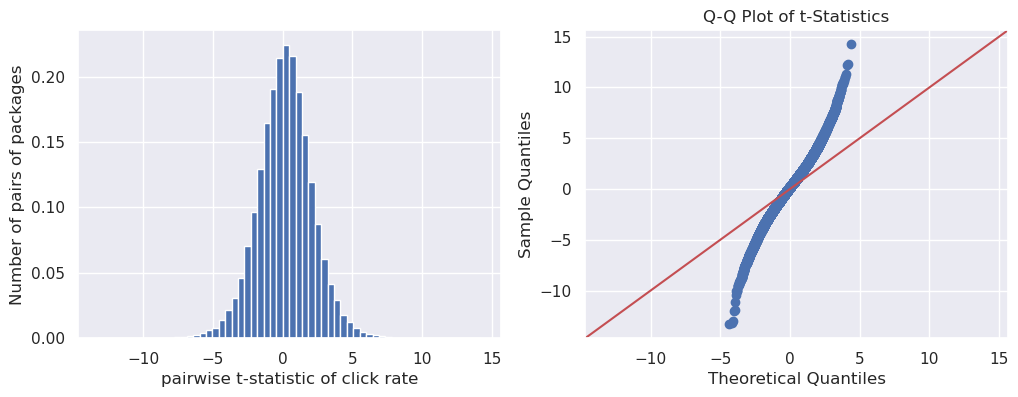

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(t_stat.t_stat, bins=60, density=True)
plt.xlabel('pairwise t-statistic of click rate')
plt.ylabel('Number of pairs of packages')

sm.qqplot(t_stat.t_stat, line='45', ax=plt.subplot(122))
plt.title('Q-Q Plot of t-Statistics')
plt.show()

In [ ]:
packages['headline_length'] = packages['headline'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
packages['syllable_count'] = packages['headline'].apply(lambda x: textstat.syllable_count(x))
packages['flesch_reading_ease'] = packages['headline'].apply(lambda x: textstat.flesch_reading_ease(x))
packages['flesch_grade_level'] = packages['headline'].apply(lambda x: textstat.flesch_kincaid_grade(x))
packages['gunning_fog'] = packages['headline'].apply(lambda x: textstat.gunning_fog(x))
packages['smog_index'] = packages['headline'].apply(lambda x: textstat.smog_index(x))
packages['automated_readability_index'] = packages['headline'].apply(lambda x: textstat.automated_readability_index(x))
packages['coleman_liau_index'] = packages['headline'].apply(lambda x: textstat.coleman_liau_index(x))
packages['linsear_write_formula'] = packages['headline'].apply(lambda x: textstat.linsear_write_formula(x))
packages['dale_chall_readability_score'] = packages['headline'].apply(lambda x: textstat.dale_chall_readability_score(x))
packages['difficult_words'] = packages['headline'].apply(lambda x: textstat.difficult_words(x))
packages['text_standard'] = packages['headline'].apply(lambda x: textstat.text_standard(x))

In [ ]:
packages.describe()

,impressions,clicks,headline_length,syllable_count,flesch_reading_ease,flesch_grade_level,click_rate,gunning_fog,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score,difficult_words
count,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000,150816.000000
mean,3569.051241,54.255908,15.008116,19.966628,80.238938,5.087054,0.015789,7.118444,0.178216,6.141992,6.921211,6.037409,8.275651,2.135834
std,1435.999476,45.521320,3.034556,3.889822,24.989913,3.730534,0.012371,3.055742,1.036419,3.333798,3.796802,2.611237,2.325233,1.376004
min,1.000000,0.000000,1.000000,1.000000,-7069.790000,-3.500000,0.000000,0.400000,0.000000,-5.200000,-28.010000,-0.500000,0.150000,0.000000
25%,2745.000000,25.000000,13.000000,17.000000,71.140000,3.200000,0.007458,4.800000,0.000000,3.900000,4.490000,3.750000,6.860000,1.000000
50%,3117.000000,42.000000,15.000000,20.000000,81.630000,5.200000,0.012509,6.800000,0.000000,6.200000,6.570000,6.000000,8.190000,2.000000
75%,4089.000000,70.000000,17.000000,23.000000,91.780000,6.800000,0.020386,8.750000,0.000000,8.200000,9.030000,8.000000,9.630000,3.000000
max,36908.000000,975.000000,36.000000,86.000000,121.220000,999.600000,0.183401,41.200000,10.500000,403.000000,470.800000,14.500000,40.630000,8.000000


Group the packages by test_id, then look at the groups that contains the same test_id but different headlines, and see if the headline with the lower grade level is more likely to be clicked on.
We can evaluate with the Spearman correlation coefficient.

In [ ]:
# key = 'headline_length'
# key = 'syllable_count'
# key = 'flesch_reading_ease'
# key = 'flesch_grade_level'
# key = 'gunning_fog'
# key = 'smog_index'
# key = 'automated_readability_index'
# key = 'coleman_liau_index'
# key = 'linsear_write_formula'
# key = 'dale_chall_readability_score'
# key = 'difficult_words'
key = 'text_standard'

result = pd.DataFrame(columns=['statistic', 'pvalue'], index=tests.groups.keys())

for test_id, test in tests:
    if test[key].nunique() == 1 or test['click_rate'].nunique() == 1:
        continue
    r = spearmanr(test[key], test['click_rate'])
    result.loc[test_id] = [r.correlation, r.pvalue]
    

result.mean()

statistic    0.010398
pvalue       0.487625
dtype: object

<Axes: ylabel='Frequency'>

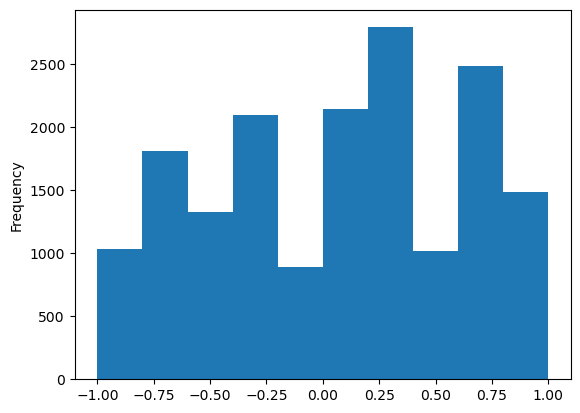

In [ ]:
result.statistic.plot(kind='hist')